In [1]:
import sys

sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM#,MNIST_SResFITDM_Large,Omniglot
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
from pytorch_lightning import seed_everything

import seaborn as sns



seed_everything(22122020)
dataset = "MNIST"
if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=32, subset_flag=False)
# if dataset == "MNIST_large":
#     dm = MNIST_SResFITDM_Large(root_dir="./datamodules/data/",
#                             batch_size=2, subset_flag=False)
# if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=8, subset_flag=False)
# if dataset == "omniglot":
#     dm = Omniglot(root_dir="./datamodules/data/",batch_size=8, subset_flag=False)

dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)


model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order)

for fc, (mag_min, mag_max) in dm.test_dataloader():
        break
fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')

gt = fc[:, flatten_order]
fc = fc[:, model.dst_flatten_order]

/localscratch/miniforge3/envs/SSM_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020


In [24]:
noise = [torch.normal(0,i,(1,2016)) for i in np.arange(0,1,0.001)]

fc_noisy = fc.clone()
PList = []
for i in noise:
    fc_noisy[...,0] = fc[...,0] + i.cuda()
    fc_noisy[...,0] = torch.clamp(fc_noisy[...,0], min=-1, max = 1)
    noisy_img = model.convert2img(fc=fc_noisy, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=gt, mag_min=mag_min, mag_max=mag_max)
    PList.append(PSNR(gt_img, noisy_img).mean().cpu().numpy())

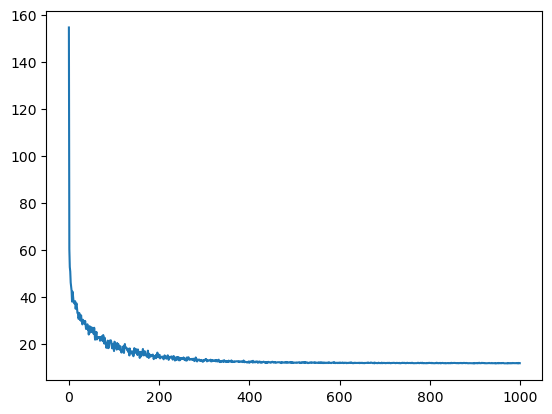

In [25]:
plt.plot(range(len(noise)), PList)